In [1]:
%matplotlib inline

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

#Reading the preprocessed data into final
final = sqlite3.connect('./amazon_food_reviews/final.sqlite')

In [2]:
final_data=pd.read_sql_query("""SELECT * FROM Reviews """, final)

In [25]:
print(final_data.shape)
print(final_data.columns)
final_data['Score'].value_counts()

(364171, 13)
Index(['index', 'Id', 'ProductId', 'UserId', 'ProfileName',
       'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time',
       'Summary', 'Text', 'CleanedText', 'WordCount'],
      dtype='object')


positive    307061
negative     57110
Name: Score, dtype: int64

*Compared to positive reviews negative reviews are very less.*

*As there are many features out of which 'Summary' and 'Text' are more useful for us to analyse*

In [4]:
#Sampling the data points
i = np.random.choice(np.arange(final_data.shape[0]), 5000, replace=False)
sampled_data = final_data.loc[i]
sampled_data.shape

(5000, 13)

In [5]:
#Bow
bow_vectors=CountVectorizer().fit_transform(sampled_data['Text'].values)
print(bow_vectors.shape)
np.save('bow_vectors1',bow_vectors.toarray())
final_bow=bow_vectors.toarray()


(5000, 15032)


*After converting the reviews from text to vectors through Bag Of Words the dimension of each vector is found to be 15032 which is of very large i.e, there are total of 15032 unique words.*

In [22]:
type(bow_vectors)

scipy.sparse.csr.csr_matrix

*As it is seen that the matrix  is sparse which means most of the points in the matrix are zero.*

In [6]:
labels=sampled_data['Score']

In [82]:
#Standardizing the data to apply TSNE on it.
from sklearn.preprocessing import StandardScaler
standardized_data=StandardScaler().fit_transform(final_bow)
print(standardized_data.shape)

C:\Users\tulasi ram\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(5000, 15005)


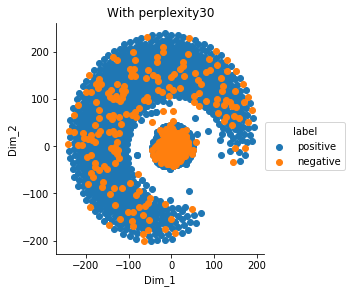

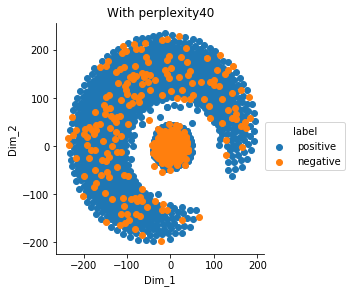

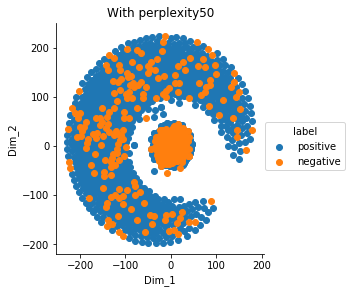

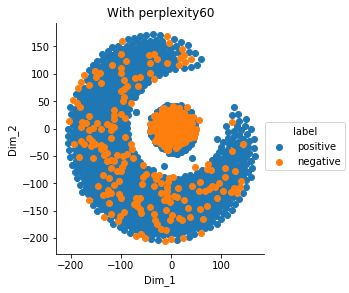

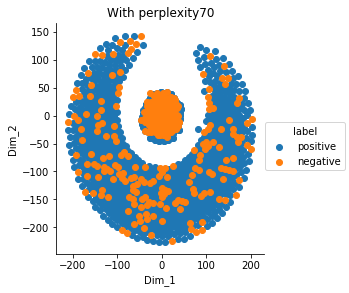

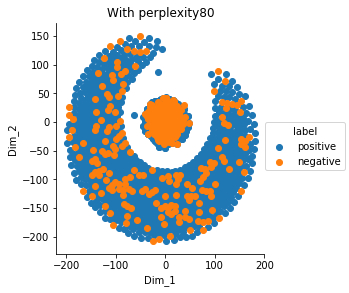

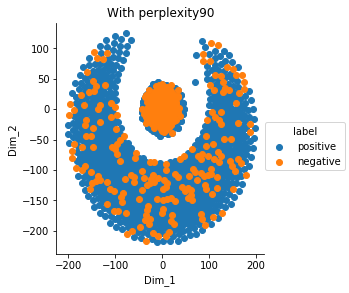

In [84]:
from sklearn.manifold import TSNE
for i in range(30,100,10):
    model=TSNE(n_components=2,random_state=0,perplexity=i,n_iter=5000)
    tsne_data=model.fit_transform(standardized_data)
    tsne_data = np.vstack((tsne_data.T, labels)).T
    tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2","label"))
    g=sns.FacetGrid(tsne_df,hue='label',size=4).map(plt.scatter,'Dim_1','Dim_2').add_legend()
    plt.title("With perplexity" +str(i))
    g.savefig("With perplexity" +str(i))
    plt.show()

**INFERENCE**

Data is overlapped at all perplexity values from 30 to 90 much by which we are not able to divide the postive and negative reviews.

In [11]:
#TF-IDF
tf_idf_vect = TfidfVectorizer(ngram_range=(1,1))
final_tf_idf = tf_idf_vect.fit_transform(sampled_data['Text'][0:2000].values)
print(final_tf_idf.shape)
final_tf_idf_vectors=final_tf_idf.toarray()

(2000, 9735)


In [7]:
from sklearn.preprocessing import StandardScaler
standardized_data=StandardScaler().fit_transform(final_tf_idf_vectors)
print(standardized_data.shape)

(2000, 9406)


In [12]:
labels_for_tfidf=sampled_data['Score'][0:2000]

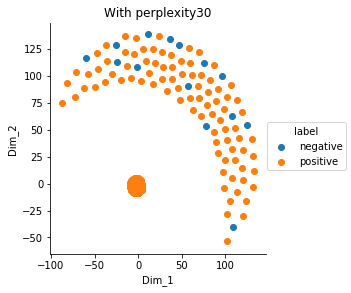

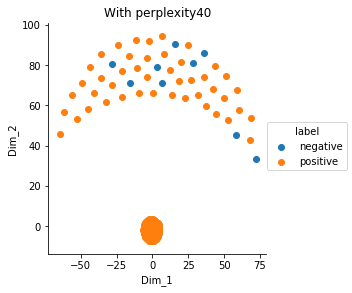

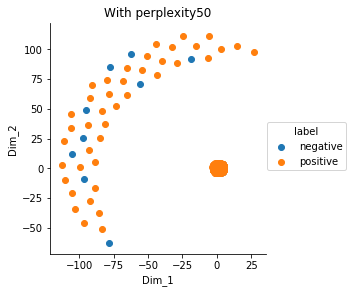

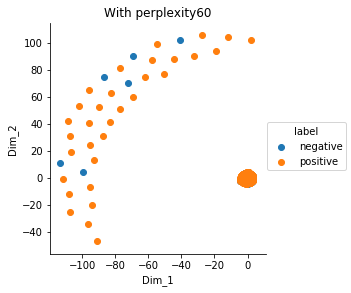

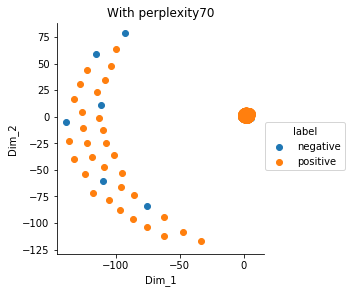

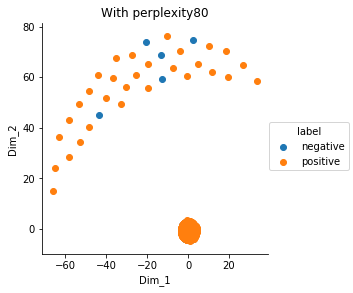

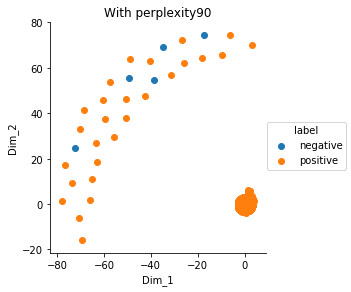

In [13]:
from sklearn.manifold import TSNE
for i in range(30,100,10):
    model=TSNE(n_components=2,random_state=0,perplexity=i,n_iter=5000)
    tsne_data=model.fit_transform(standardized_data)
    tsne_data = np.vstack((tsne_data.T, labels_for_tfidf)).T
    tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2","label"))
    g=sns.FacetGrid(tsne_df,hue='label',size=4).map(plt.scatter,'Dim_1','Dim_2').add_legend()
    plt.title("With perplexity" +str(i))
    g.savefig("With perplexity" +str(i))
    plt.show()

In [7]:
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned


In [8]:

# Train our own Word2Vec model using our own text corpus
# cleaning the word of any html-tags
#cleaning the word of any punctuation or special characters
import gensim
i=0
list_of_sent=[]
for sent in sampled_data['Text'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)
    

C:\Users\tulasi ram\Anaconda3\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [9]:
#Word2Vec
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=4)    


In [30]:
w2v_model.save('word2vec')

In [31]:
#AvgW2V Model
sent_vectors = []; 
for sent in list_of_sent: 
    sent_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent:
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)

In [32]:
#Standardizing the data to apply TSNE on it.
from sklearn.preprocessing import StandardScaler
standardized_data=StandardScaler().fit_transform(sent_vectors)
print(standardized_data.shape)

(5000, 50)


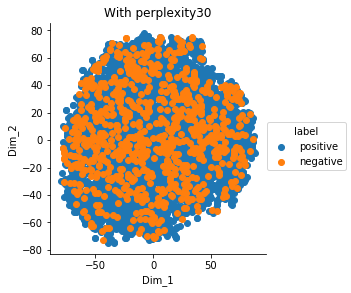

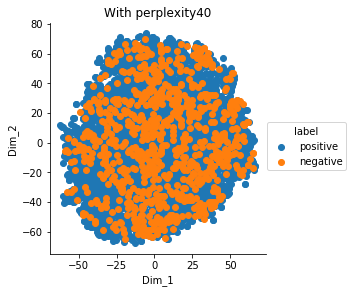

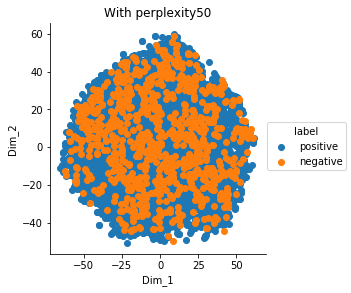

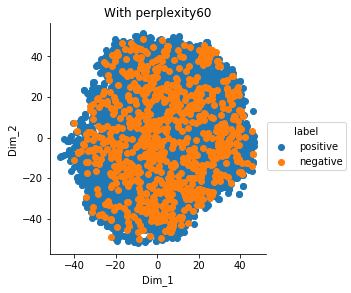

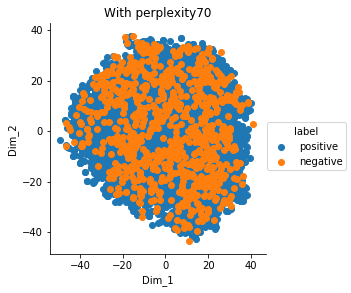

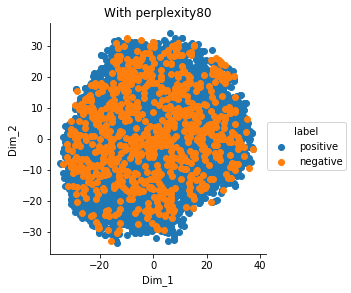

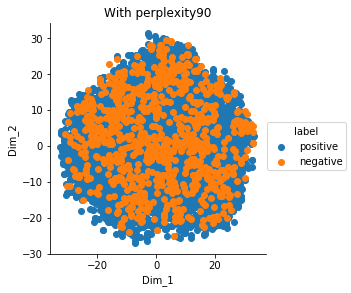

In [35]:
from sklearn.manifold import TSNE
for i in range(30,100,10):
    model=TSNE(n_components=2,random_state=0,perplexity=i,n_iter=5000)
    tsne_data=model.fit_transform(standardized_data)
    tsne_data = np.vstack((tsne_data.T, labels)).T
    tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2","label"))
    g=sns.FacetGrid(tsne_df,hue='label',size=4).map(plt.scatter,'Dim_1','Dim_2').add_legend()
    plt.title("With perplexity" +str(i))
    g.savefig("With perplexity" +str(i))
    plt.show()

**INFERENCE**

By seeing the tsne plots of word2vec it is clear that all the points are overlapping at all perplexity values from 30 to 90 .It seems like a sort of random data and we cannot divide the data into positive and negative points.

In [12]:
#TF-IDF-W2V
tf_idf_features=tf_idf_vect.get_feature_names()
tf_idf_sent_vectors=[]
row=0
for sent in list_of_sent:
    sent_vec=np.zeros(50)
    weight_sum=0
    for word in sent:
        try:
            vec=w2v_model.wv[word]
            tf_idf=final_tf_idf[row,tf_idf_features.index(word)]
            sent_vec+=(vec*tf_idf)
            weight_sum+=tf_idf
        except:
            pass
    sent_vec/=weight_sum
    tf_idf_sent_vectors.append(sent_vec)
    row+=1
    

C:\Users\tulasi ram\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


In [17]:
tf_idf_sent_vectors=np.nan_to_num(tf_idf_sent_vectors)

In [18]:
from sklearn.preprocessing import StandardScaler
standardized_data=StandardScaler().fit_transform(tf_idf_sent_vectors)
print(standardized_data.shape)

(5000, 50)


In [19]:
labels=sampled_data['Score']

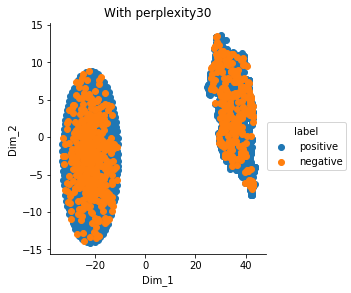

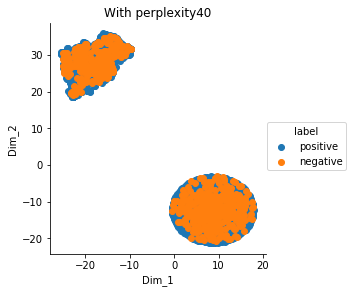

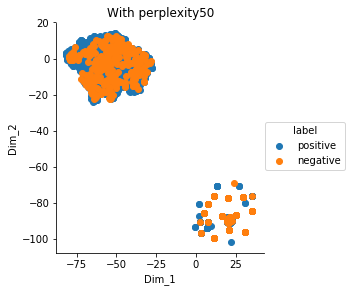

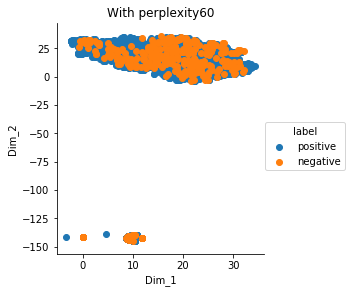

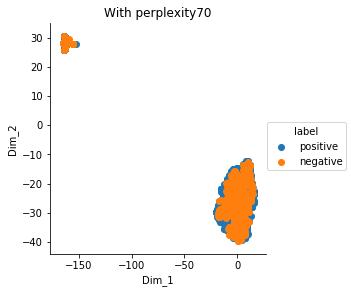

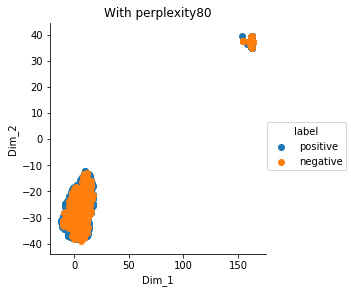

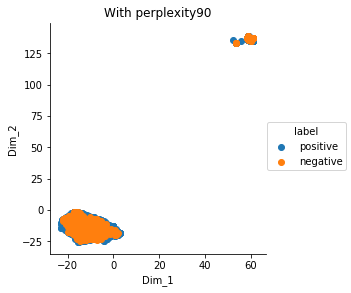

In [20]:
from sklearn.manifold import TSNE
for i in range(30,100,10):
    model=TSNE(n_components=2,random_state=0,perplexity=i,n_iter=5000)
    tsne_data=model.fit_transform(standardized_data)
    tsne_data = np.vstack((tsne_data.T, labels)).T
    tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2","label"))
    g=sns.FacetGrid(tsne_df,hue='label',size=4).map(plt.scatter,'Dim_1','Dim_2').add_legend()
    plt.title("With perplexity" +str(i))
    g.savefig("With perplexity" +str(i))
    plt.show()

**INFERENCE**

All the data points are overlapped .